In [52]:
import os, string, json
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import matplotlib.pyplot as plt

ALL_DOMAINS = ['excel', 'servicenow', 'jupyter', 'dbt', 'airflow', 'dagster', 'airbyte', 'snowflake', 'bigquery', 'superset', 'metabase']
SCOPES = ["https://www.googleapis.com/auth/spreadsheets"]
SPREADSHEET_ID = "1gJNk_ndBTH4tib1gyzLUKRcmDT-z4s5o0CGR8rFsU-g"
client_secrets = 'client_secrets.json'
credentials = 'credentials.json'

def get_sheet():
    creds = None
    os.environ['http_proxy'] = 'http://127.0.0.1:58591'
    os.environ['https_proxy'] = 'http://127.0.0.1:58591'
    if os.path.exists(credentials):
        creds = Credentials.from_authorized_user_file(credentials, SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                client_secrets, SCOPES
            )
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open(credentials, "w") as token:
            token.write(creds.to_json())
    try:
        service = build("sheets", "v4", credentials=creds)
        # Call the Sheets API
        sheet = service.spreadsheets()
    except HttpError as err:
        print(err)
    return sheet


def get_tools(sheet):
    result = sheet.get(spreadsheetId=SPREADSHEET_ID).execute().get("sheets", [])
    tools = [res["properties"]['title'] for res in result if res["properties"]['title'] not in ['sources', 'tutorials']]
    return tools


def get_validated_number(sheet):
    tools = get_tools(sheet)
    result = {}
    for tool in tools:
        range = f'{tool}!A1:K50' # extract each tool's data
        response = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=range).execute()
        values = response.get("values", [])
        annotated, validated = 0, 0
        # column H, I, K -> Done, Validated, Passed
        for i, row in enumerate(values):
            if i == 0: continue
            done, verbose, passed = '', '', ''
            if len(row) >= 8: done = row[7]
            if len(row) >= 9: verbose = row[8]
            if len(row) >= 11: passed = row[10]
            if done == "✅": annotated += 1
            if done == "✅" and verbose == "✅" and passed == "✅": validated += 1
        result[tool] = {'annotated': annotated, 'validated': validated}
    result['total'] = {'annotated': sum([result[t]['annotated'] for t in tools]), 'validated': sum([result[t]['validated'] for t in tools])}
    return result


def get_validated_uuids(sheet):
    tools = get_tools(sheet)
    result = {}
    for tool in tools:
        range = f'{tool}!A1:K50' # extract each tool's data
        response = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=range).execute()
        values = response.get("values", [])
        validated_uuids = []
        # column H, I, K -> Done, Validated, Passed
        for i, row in enumerate(values):
            if i == 0: continue
            done, verbose, passed = '', '', ''
            if len(row) >= 8: done = row[7]
            if len(row) >= 9: verbose = row[8]
            if len(row) >= 11: passed = row[10]
            if done == "✅" and verbose == "✅" and passed == "✅":
                validated_uuids.append(row[0].strip())
        result[tool] = validated_uuids
    return result

def get_aggregated_result_from_sheet(sheet, column_char: str):
    column_char = column_char.upper()
    column_index = string.ascii_uppercase.index(column_char)
    result_dict = {}
    method = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=f'dbt!{column_char}1:{column_char}1').execute().get('values', [])[0][0]
    for tool in ALL_DOMAINS:
        data_range = f'{tool}!A1:X50'
        response = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=data_range).execute()
        values = response.get("values", [])
        result_dict[tool] = {'total': 0, 'unfinished': 0, 'outliers': 0, 'success': 0, "failed": 0}
        for rid, row in enumerate(values):
            if rid == 0:
                if len(row) <= column_index:
                    print(f'No method title for {tool} in column {column_char}, which should be {method}')
                    break
                assert row[column_index] == method, f"Method title for {tool} is {row[column_index]} instead of the desired {method}"
            if len(row) < 8 or row[7] != "✅": # this example is not annotated yet, just skip
                continue
            result_dict[tool]['total'] += 1
            if len(row) <= column_index or str(row[column_index]) == "": # result not available yet
                result_dict[tool]['unfinished'] += 1
                continue
            result = str(row[column_index])
            if result not in ["0", "1"]:
                print(f'[WARNING]: result for {tool}/{row[0]} and method {method} (column {column_char}) is {result}, neither 0 nor 1')
                result_dict[tool]['outliers'] += 1
                continue
            if result == "1":
                result_dict[tool]['success'] += 1
            else: result_dict[tool]['failed'] += 1
        assert result_dict[tool]['success'] + result_dict[tool]['failed'] == result_dict[tool]['total'] - result_dict[tool]['outliers'] - result_dict[tool]['unfinished']
        if result_dict[tool]['success'] + result_dict[tool]['failed'] == 0: rate = 0.0
        else:
            rate = result_dict[tool]['success'] * 100.0 / (result_dict[tool]['success'] + result_dict[tool]['failed'])
        result_dict[tool]['rate'] = rate
        print(f'For {tool}: total={result_dict[tool]["total"]}, unfinished={result_dict[tool]["unfinished"]}, outliers={result_dict[tool]["outliers"]}, success={result_dict[tool]["success"]}, failed={result_dict[tool]["failed"]}, success_rate={result_dict[tool]["success"]}/{result_dict[tool]["success"] + result_dict[tool]["failed"]}={result_dict[tool]["rate"]:.2f}%')
    total = sum([result_dict[tool]['total'] for tool in result_dict])
    unfinished = sum([result_dict[tool]['unfinished'] for tool in result_dict])
    outliers = sum([result_dict[tool]['outliers'] for tool in result_dict])
    success = sum([result_dict[tool]['success'] for tool in result_dict])
    failed = sum([result_dict[tool]['failed'] for tool in result_dict])
    rate = success * 100.0 / (success + failed)
    result_dict['total'] = {'total': total, 'unfinished': unfinished, 'outliers': outliers, 'success': success, 'failed': failed, 'rate': rate}
    print(f'In total, {total} samples, {unfinished} unfinished, {outliers} outliers, {success} success, {failed} failed, success_rate={rate:.2f}% for method {method}')
    return result_dict


def write_result_dict_into_sheet(sheet, result_dict, column_name: str, column_char: str = "", column_index: int = -1):
    column_char = column_char.upper()
    if column_char != "":
        if column_index >= 0:
            assert string.ascii_uppercase[column_index] == column_char
        else:
            column_index = string.ascii_uppercase.index(column_char)
    else:
        assert column_index >= 0, "Must specify at least one of column_index or column_char"
        column_char = string.ascii_uppercase[column_index]
    total = 0
    for tool in result_dict:
        data_range = f'{tool}!A1:X50' # extract each tool's data
        response = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=data_range).execute()
        values = response.get("values", [])
        tool_result = result_dict[tool]
        cell_pos = {} # uuid -> tuple (tool, row_index, int score)
        # get existing result
        for rid, row in enumerate(values):
            if rid == 0:
                if len(row) < column_index + 1:
                    # print(f'[ERROR]: please check the sheet for tool {tool}: column_index={column_index} exceeding maximum column numbers')
                    print(f'column {column_char}: "{column_name}" (index={column_index}) not exist yet, create it!')
                    data_range = f'{tool}!{column_char}1:{column_char}1'
                    body = {"values": [[column_name]]}
                    result = sheet.values().update(spreadsheetId=SPREADSHEET_ID, range=data_range, valueInputOption='RAW', body=body).execute()
                else:
                    if row[column_index].strip() != column_name:
                        print(f'[ERROR]: please check the sheet for tool {tool}: column_index={column_index} is not {column_name}')
                        break
            if len(row) == 0: continue
            eid = row[0].strip()
            if eid not in tool_result: continue
            cur_res = row[column_index] if len(row) > column_index else "" # means no value is written yet
            score = tool_result[eid]
            if str(cur_res) == "1" and int(score) == 0:
                print(f'[WARNING]: cell for row {rid} and column {column_name} has value 1 already, but new score=0. Just skip !')
                continue
            if str(cur_res) == "0" and int(score) == 1:
                print(f'[Attention]: cell for row {rid} and column {column_name} has value 0 already, will be updated to score=1 !')
            if str(cur_res) == str(int(score)): continue
            cell_pos[eid] = (tool, rid, int(score))
        
        # update result, one data point each time
        for eid in cell_pos:
            tool, rid, score = cell_pos[eid]
            data_range = f'{tool}!{column_char}{rid+1}:{column_char}{rid+1}'
            body = {"values": [[score]]}
            result = sheet.values().update(spreadsheetId=SPREADSHEET_ID, range=data_range, valueInputOption='RAW', body=body).execute()
        total += len(cell_pos)
        print(f'In total, for tool {tool}, update {len(cell_pos)} result for method {column_name} (in column {column_char})')
    print(f'In total, update {total} result for method {column_name} (in column {column_char})')


def get_dataset_statistics(data_dir='evaluation_examples/examples'):
    action_numbers = {'easy': [], 'medium': [], 'hard': []}
    total = 0
    cluster = {'cli': 0, 'gui': 0, 'cli+gui': 0, 'account': 0}
    for tool in ALL_DOMAINS:
        tool_dir = os.path.join(data_dir, tool)
        for eid in os.listdir(tool_dir):
            edir = os.path.join(tool_dir, eid)
            if not os.path.isdir(edir): continue
            fp = os.path.join(edir, f'{eid}.json')
            with open(fp, 'r') as inf:
                data = json.load(inf)
            total += 1
            if 'action_number' not in data:
                print(f'[WARNING]: no action_number for {eid}')
                continue
            hard = 'easy' if data['action_number'] <= 5 else 'medium' if data['action_number'] <= 15 else 'hard'
            action_numbers[hard].append(data['action_number'])
            if 'cli' not in data['tags'] and 'gui' not in data['tags'] and 'cli+gui' not in data['tags']:
                print(f'[WARNING]: no action_type for {tool}/{eid}')
            if len(set(data['tags']) & set(['cli', 'gui', 'cli+gui'])) >= 2:
                print(f'[WARNING]: multiple action_type for {tool}/{eid}')
            for tag in data['tags']:
                if tag in cluster: cluster[tag] += 1
                else: print(f'[WARNING]: unknown tag {tag} for {eid}')
    # plt.hist(action_numbers['easy'] + action_numbers['medium'] + action_numbers['hard'], bins=list(range(0, 60, 5)), alpha=0.5)
    # plt.show()
    print(total)
    for tag in cluster:
        print(f'For tag {tag}, {cluster[tag]} examples')
    return action_numbers, cluster

def print_output_dict(result_dict):
    for tool in result_dict:
        tool_res = result_dict[tool]
        if type(tool_res) == dict:
            msg = ", ".join([k + "=" + str(v) for k, v in tool_res.items()])
            print(f'For {tool}: {msg}')
        else:
            print(f'For {tool}: {result_dict[tool]}')



In [57]:
from show_result import get_result_dict_from_dir
sheet = get_sheet()
print_output_dict(get_validated_number(sheet))

# write data into google sheet from result directory
# result_dict = get_result_dict_from_dir('results/computer_13_a11y_tree_gpt-4o-2024-05-13')
# write_result_dict_into_sheet(sheet, result_dict, column_name="computer13-a11y-gpt4o", column_char="N")

# get result from google sheet from google sheet (other people may update result)
# results = get_aggregated_result_from_sheet(sheet, 'N')
# action_numbers, cluster = get_dataset_statistics()


For excel: annotated=31, validated=31
For jupyter: annotated=2, validated=0
For superset: annotated=11, validated=2
For metabase: annotated=18, validated=5
For dbt: annotated=20, validated=18
For dagster: annotated=20, validated=18
For airflow: annotated=22, validated=15
For airbyte: annotated=16, validated=2
For bigquery: annotated=18, validated=16
For snowflake: annotated=22, validated=13
For servicenow: annotated=29, validated=0
For total: annotated=209, validated=120


In [58]:
import json

def filter_easy_cases(validated_uuids):
    examples = {}
    for tool in validated_uuids:
        if tool not in examples:
            examples[tool] = []
        for idx in validated_uuids[tool]:
            fp = os.path.join('evaluation_examples', 'examples', tool, idx, f'{idx}.json')
            ex = json.load(open(fp, 'r'))
            if 'action_number' not in ex or type(ex['action_number']) != int or ex['action_number'] <= 0:
                print(f'[ERROR]: action_number field not valid in example {fp}')
                continue
            if int(ex['action_number']) <= 5:
                examples[tool].append(idx)
    return examples

def write_to_json(examples, file_path):
    with open(file_path, 'w') as f:
        json.dump(examples, f, indent=4, ensure_ascii=False)

def modify_metadata_in_config(example_dir='evaluation_examples/examples'):
    count = 0
    for tool in ALL_DOMAINS:
        tool_dir = os.path.join(example_dir, tool)
        for eid in os.listdir(tool_dir):
            eid_dir = os.path.join(tool_dir, eid)
            if os.path.isdir(eid_dir):
                config = os.path.join(eid_dir, f'{eid}.json')
                data = json.load(open(config, 'r'))
                for c in data['config']:
                    if c['type'] == 'google_chrome_browser' and 'urls' in c['parameters']:
                        for idx, url in enumerate(c['parameters']['urls']):
                            if 'www.google.com' in url:
                                c['parameters']['urls'][idx] = 'https://www.bing.com/'
                                count += 1
                json.dump(data, open(config, 'w'), indent=4, ensure_ascii=False)
    print('In total, modify', count, 'urls in metadata files')
modify_metadata_in_config()


In total, modify 94 urls in metadata files


In [56]:
# sheet = get_sheet()
# result = get_validated_number(sheet)
# for split in result:
#     print(f'{split}: {result[split]["annotated"]} annotated, {result[split]["validated"]} validated')
validated_uuids = get_validated_uuids(sheet)
examples = filter_easy_cases(validated_uuids)
# write_to_json(examples, 'evaluation_examples/test_easy.json')
for tool in examples:
    print(tool + ':')
    for idx in examples[tool]:
        print(f'  {idx}')
print(f'In total, {sum([len(examples[tool]) for tool in examples])} easy examples with steps <= 5 found.')


excel:
  1273e544-688f-496b-8d89-3e0f40aa0606
jupyter:
superset:
metabase:
  7c38e400-d52c-4e07-b6c6-e2b4a1b38a6d
  fdeaf4b9-6d03-4090-8b53-9487f38e3a29
  d294bf44-fed3-4958-9740-3960010bcb78
dbt:
  0aa56709-3293-5849-ad47-e377f49fd3a0
  f96a5913-1489-40bb-a432-8411b1c61533
  4b331e9f-7fcf-40d6-aa7b-ad468010f334
  1471e2d8-7f3a-4e1c-b049-1d0f0d57d344
  cb82ed0a-22b8-46c0-8aee-73548e8c8592
dagster:
  9f8eab3f-3c9f-4def-9061-43a65fd83974
  22ef9058-6188-422a-9c12-e6934e4ed936
  1a57b227-d047-4dc9-8a33-2d4d02788667
  0dff0011-afff-4ab8-ae07-83f5ab95d215
  e0796d19-945b-434f-8c25-708a667e021e
airflow:
  699e0c0a-3fdc-4c10-ad9f-c4c9d7a9947b
  57a13efe-c008-4bc9-8959-36276115da0b
  67ee22b5-caf1-4aa9-92c5-57546b3d823c
  13d420b9-b685-4afb-ac98-997cbbd266d9
  33c8ce09-de8b-4432-8308-603b98513fdc
  3e8ddf14-a503-4ba1-83d0-32b2d91b33bb
airbyte:
bigquery:
  950f4d46-c41c-49d0-b120-33ba722d82fd
  4b34d5ea-ea0a-40b2-a75c-6b03213a5ba8
  3d115d4f-2a4c-4133-a56d-ddd13b8b4916
snowflake:
  6ced40b9-7bd

In [9]:
uuids = """
5b70dd26-8c60-43ea-b388-082a6f603fe5
d67180b5-d45c-4425-b222-236743fd6f88
56663e79-7939-48a7-80fa-bcc30046d233
17ccf8bb-a172-42cf-a3c9-9d91fb8e6998
8c559ef7-dc13-49db-9822-8547ac052715
986a06f9-f322-4e46-8f28-9122a49fc512
82f70410-8366-437d-bdf7-d83ff2d5a3d7
b1c52dc9-35a6-4ed3-8726-3920ffd1e752
1f515ecc-b4a4-4ddb-9f7d-2a3638ae7fd4
aee8dd36-08b5-4e29-ab33-1392b5e73e27
eae9d8bd-32a5-4b50-b495-8e5d8a5967e8
7dea9a73-38de-464c-93d4-792e88ab13f9
91e6dbc0-c045-4ded-bb21-32e5f45e9bab
f95f676c-65a5-4834-9005-fb6bfaf7514c
1b644d39-1df5-48ac-ad79-7dfdc91ba8cd
19f425aa-8595-47bd-84ac-08052d46c4b3
070b87f5-8a6f-4bb4-a7df-d4e9274fae21
018a12a9-faeb-4427-a758-a40a58dc29f5
f3527b38-81f9-4abc-9293-cd43217fae9d
d67a3852-63c0-4064-a2d2-d093a136ce77
36b75163-2744-4627-a153-aaf259ba927b
cda87442-43d4-4e6a-882f-50b5be8bf121
5f5b4549-bd6b-4332-9ca2-2fe604994f07
3b9da56c-4e9f-455f-b91b-6147cafe44e3
"""
uuids = [idx for idx in uuids.split("\n") if idx.strip() != ""]
import json
fp = [f'evaluation_examples/examples/servicenow/{uid}/{uid}.json' for uid in uuids]
for f in fp:
    data = json.load(open(f, 'r'))
    del data['evaluator']['result']['listening_port']
    json.dump(data, open(f, 'w'), indent=4, ensure_ascii=False)

In [37]:
import os, json, logging, platform
from google.cloud import bigquery
from google.oauth2 import service_account

keyfile_path = 'evaluation_examples/settings/google/apt-rite-415611.json'
project_id = 'apt-rite-415611'
credentials = service_account.Credentials.from_service_account_file(keyfile_path)
os.environ['http_proxy'], os.environ['https_proxy'] = 'http://127.0.0.1:58591', 'http://127.0.0.1:58591'
client = bigquery.Client(project=project_id, credentials=credentials)

In [6]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive, GoogleDriveFile, GoogleDriveFileList
os.environ['http_proxy'], os.environ['https_proxy'] = 'http://127.0.0.1:58591', 'http://127.0.0.1:58591'
settings = 'settings.yaml'
gauth = GoogleAuth(settings_file=settings)
drive = GoogleDrive(gauth)
print(drive.ListFile({'q': ""}).GetList())
# for file in drive.ListFile({'q': ""}).GetList():
    # try:
        # file.Delete()
    # except: pass

/Users/rhythmcao/miniforge3/envs/desktop-env/lib/python3.11/site-packages/oauth2client/_helpers.py:255: UserWarning: Cannot access creds.json: No such file or directory
  warnings.warn(_MISSING_FILE_MESSAGE.format(filename))


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=905597626417-4oqbi9hph2qven2mhiuolahc6qftr55t.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code&approval_prompt=force

Authentication successful.
[]


In [32]:
import os, shutil, json
examples = """
1e8df695-bd1b-45b3-b557-e7d599cf7597
1273e544-688f-496b-8d89-3e0f40aa0606
4172ea6e-6b77-4edb-a9cc-c0014bd1603b
0326d92d-d218-48a8-9ca1-981cd6d064c7
26a8440e-c166-4c50-aef4-bfb77314b46b
1954cced-e748-45c4-9c26-9855b97fbc5e
535364ea-05bd-46ea-9937-9f55c68507e8
4de54231-e4b5-49e3-b2ba-61a0bec721c0
1de60575-bb6e-4c3d-9e6a-2fa699f9f197
0a2e43bf-b26c-4631-a966-af9dfa12c9e5
3a7c8185-25c1-4941-bd7b-96e823c9f21f
04d9aeaf-7bed-4024-bedb-e10e6f00eb7f
42e0a640-4f19-4b28-973d-729602b5a4a7
1d17d234-e39d-4ed7-b46f-4417922a4e7c
21ab7b40-77c2-4ae6-8321-e00d3a086c73
30e3e107-1cfb-46ee-a755-2cd080d7ba6a
12382c62-0cd1-4bf2-bdc8-1d20bf9b2371
035f41ba-6653-43ab-aa63-c86d449d62e5
51719eea-10bc-4246-a428-ac7c433dd4b3
0acbd372-ca7a-4507-b949-70673120190f
852527e8-1b97-466c-a12f-b6b095df59bc
b6e9778c-11b3-455f-b720-655048787484
65551792-4c32-4904-983d-7c68c189b474
fe29cdf3-d317-47b3-a657-d61f97f00b88
5f8601f8-6e90-4d2c-91bb-eb5836ad1d5c
f654bf9a-dea2-472d-a877-edeeb12d7462
97dd78c1-4ba3-4bfd-bbd4-c938532dbcc6
8909d1cb-5877-44c7-a908-9f1875302441
de7a24c3-7f47-45c7-bba9-ba1aaaf015f8
9ed02102-6b28-4946-8339-c028166e9512
cd3c4994-b9e2-426b-8157-f7978ff55501
"""
ex_ids = list(filter(lambda x: x.strip() != '', examples.split('\n')))
directory = 'evaluation_examples/examples/sheetcopilot'
count = 0
for ex in os.listdir(directory):
    if not os.path.isdir(os.path.join(directory, ex)):
        continue
    ex = json.load(open(os.path.join(directory, ex, f'{ex}.json')))
    ex['snapshot'] = 'excel'
    if 'related_apps' not in ex:
        ex['related_apps'] = ['excel']
    if 'tags' not in ex:
        ex['tags'] = ['gui']
    ex['related_apps'] = [app.lower() for app in ex['related_apps']]
    ex['tags'] = [tag.lower() for tag in ex['tags']]
    if 'abstract' in ex['tags']:
        ex['tags'].remove('abstract')
    if 'cli' in ex['tags']:
        ex['tags'].remove('cli')
    if 'cli+gui' in ex['tags']:
        ex['tags'].remove('cli+gui')
    if 'gui' not in ex['tags']:
        ex['tags'].append('gui')
    if 'excel' not in ex['related_apps']:
        ex['related_apps'].append('excel')
    if 'libreoffice_calc' in ex['related_apps']:
        ex['related_apps'].remove('libreoffice_calc')
    if ex['related_apps'] != ['excel']:
        print(ex['id'] + ' ' + str(ex['related_apps']))
    if ex['tags'] != ['gui']:
        print(ex['id'] + ' ' + str(ex['tags']))
    json.dump(ex, open(os.path.join(directory, ex['id'], f'{ex["id"]}.json'), 'w'), indent=4, ensure_ascii=False)
# print(count)
# print(len(ex_ids))
# print(len(os.listdir(directory)))
# for ex in filter(lambda x: x.strip() != '', examples.split('\n')):
    # fp = os.path.join('evaluation_examples', 'examples', 'sheetcopilot', ex)

In [23]:
import os, json
from collections import defaultdict, Counter

counter, total = defaultdict(lambda: 0), 0

tools = ['bigquery', 'dagster', 'dbt', 'airflow', 'metabase', 'superset', 'airbyte', 'snowflake', 'sheetcopilot', 'jupyter']
for tool in tools:
    subdir = os.path.join('evaluation_examples/examples', tool)
    for ex_id in os.listdir(subdir):
        fp = os.path.join(subdir, ex_id)
        if os.path.isdir(fp):
            ex = os.path.join(fp, ex_id + '.json')
            # verbose = os.path.join(fp, 'verbose_instruction.txt')
            # if os.path.exists(verbose):
                # counter.append(1)
            total += 1
            with open(ex, 'r', encoding='utf8') as inf:
                data = json.load(inf)
            if 'action_number' in data:
                if data['action_number'] <= 5:
                    counter['easy'] += 1
                elif data['action_number'] <= 15:
                    counter['medium'] += 1
                elif data['action_number'] <= 30:
                    counter['hard'] += 1
                else:
                    counter['extra'] += 1
                # counter.append(data['action_number'])
            # if 'tags' in data:
                # data['tags'] = [x.lower() for x in data['tags']]
            # else:
                # print(data['snapshot'])
                # print(ex_id)
                # if 'cli' in data['tags']:
                #     counter.append('cli')
                # elif 'cli+gui' in data['tags']:
                #     counter.append('cli+gui')
                # elif 'gui' in data['tags']:
                #     counter.append('gui')
                # if len(set(data['tags']) & set({'cli', 'gui', 'cli+gui'})) != 1:
                    # print(ex_id)
# counter = Counter(counter)
print(counter)

defaultdict(<function <lambda> at 0x1255b27a0>, {'medium': 52, 'easy': 31, 'hard': 6, 'extra': 1})


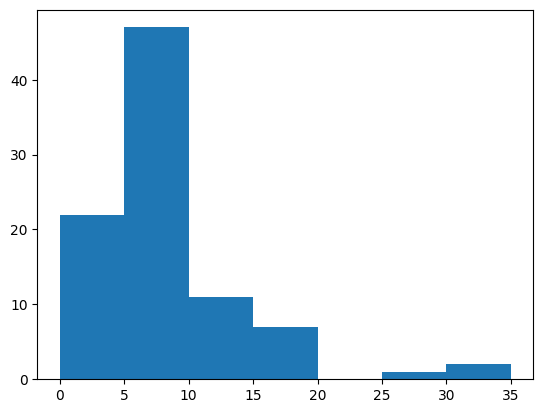

<Figure size 640x480 with 0 Axes>

In [8]:
from matplotlib import pyplot as plt

plt.hist(counter, bins=range(0, 40, 5))
plt.show()
plt.savefig('action_number.png')

In [1]:
import json
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery.dataset import DatasetListItem
from google.cloud.bigquery.table import TableListItem

In [2]:
import os
os.path

<module 'posixpath' (frozen)>

In [ ]:
credentials = service_account.Credentials.from_service_account_file('evaluation_examples/settings/google/apt-rite-415611.json')
project_id, dataset_id, table_id = 'apt-rite-415611', 'babynames', 'names_2014'
client = bigquery.Client(project=project_id, credentials=credentials)
# query = f"SELECT name, assigned_sex_at_birth, count FROM {project_id}.{dataset_id}.{table_id}"
query = f"SELECT name, assigned_sex_at_birth, count FROM apt-rite-415611.babynames.names_2014"
job = client.query(query)
df = job.to_dataframe()

In [ ]:
data_list = list(df.itertuples(index=False, name=None))
output_csv_path = 'output.csv'
df.to_csv(output_csv_path, index=False, header=False)

In [ ]:
config = {
    "schema_from_json": [
                            {
                                "name": "name",
                                "type": "STRING"
                            },
                            {
                                "name": "assigned_sex_at_birth",
                                "type": "STRING"
                            },
                            {
                                "name": "count",
                                "type": "INTEGER"
                            }
                        ]
}

schema = [bigquery.SchemaField(s["name"], s.get('type', "STRING"), mode=s.get('mode', "NULLABLE")) for s in config['schema_from_json']]

In [ ]:
table_ref = f'{project_id}.{dataset_id}.{table_id}' + '4'
client.create_table(bigquery.Table(table_ref, schema=schema))

In [ ]:
#coding=utf8
import logging
import requests, time, platform
from playwright.sync_api import sync_playwright, expect
import json, sys, os, re
import argparse, sys, subprocess
from desktop_env.controllers.setup import SetupController

logger = logging.getLogger()

parser = argparse.ArgumentParser(description="web crawling example")
parser.add_argument('-p', '--path', type=str, required=True, help='Path to the virtual machine .vmx file')
parser.add_argument('-s', '--snapshot', type=str, required=True, help='Name of the snapshot to restore')
args = parser.parse_args(sys.argv[1:])
stdout_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_handler)
logger.setLevel(logging.INFO)

p = subprocess.Popen(["vmrun", "-T", "ws", "revertToSnapshot", args.path, args.snapshot])
p.wait()
p = subprocess.Popen(["vmrun", "-T", "ws", "start", args.path])
p.wait()
vm_ip = subprocess.run(["vmrun", "-T", "ws", "getGuestIPAddress", args.path, "-wait"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, timeout=60, text=True, encoding="utf-8").stdout.strip()
print('VM IP: %s' % vm_ip)

setup_controller = SetupController(vm_ip=vm_ip, cache_dir='tmp')
setup_controller._launch_setup(command=["google-chrome", "--remote-debugging-port=1337"])
setup_controller._launch_setup(command=["socat", "tcp-listen:9222,fork", "tcp:localhost:1337"])

host = setup_controller.vm_ip
port = 9222
remote_debugging_url = f"http://{host}:{port}"


def extract_content(page, url):
    page.goto(url)
    page.wait_for_load_state('load')
    output = []
    time.sleep(5)
    button = page.locator('button#list-view-option-detailed')
    expect(button).to_be_enabled(timeout=5000)
    button.click()
    item_list = page.locator('#__next section div.ipc-page-grid.ipc-page-grid--bias-left > div > ul')
    expect(item_list).to_be_visible()
    items = item_list.locator('li')
    time.sleep(10)
    for row in items.all():
        cur_output = []
        text = row.locator('div.sc-f24f1c5c-3.fRBzBY a h3').inner_text().strip()
        ranking, title = re.search(r'(\d+)\. (.*?)$', text).groups()
        cur_output.append(ranking)
        cur_output.append(title)
        year = row.locator('div > div > div > div.sc-f24f1c5c-3.fRBzBY > div.sc-be6f1408-0.gVGktK > div.sc-be6f1408-7.iUtHEN.dli-title-metadata > span:nth-child(1)').inner_text().strip()
        cur_output.append(year)
        star = row.locator('div > div > div > div.sc-f24f1c5c-3.fRBzBY > div.sc-be6f1408-0.gVGktK > span > div > span').get_attribute('aria-label').strip()
        star = re.search(r'IMDb rating: ([\d\.]+)$', star, flags=re.I).group(1)
        desc = row.locator('div > div > div > div.sc-f24f1c5c-2.ffDWee > div[role="presentation"]').inner_text().strip()
        cur_output.append(star)
        cur_output.append(desc)
        output.append(cur_output)
    return output


def write_seen(output, output_file, headers=[]):
    import pandas as pd
    import random
    from collections import OrderedDict

    # Creating a DataFrame
    data = OrderedDict()
    orders = list(range(len(output)))
    random.shuffle(orders)
    output = [output[idx] for idx in orders]
    for idx, h in enumerate(headers):
        if idx == 0: continue
        data[h] = []
        for row in output:
            data[h].append(row[idx])

    df = pd.DataFrame(data)
    df.to_excel(output_file, engine='openpyxl', index=False)
    return output_file


def write_unseen(output, output_file, headers=[]):
    import pandas as pd
    from collections import OrderedDict

    # Creating a DataFrame
    data = OrderedDict()
    for idx, h in enumerate(headers):
        if idx == 0: continue
        data[h] = []
        for entry in output:
            if int(entry[2]) < 2024 and int(entry[0]) <= 30:
                data[h].append(entry[idx])

    df = pd.DataFrame(data)
    df.to_excel(output_file, engine='openpyxl', index=False)
    return output_file


def get_browser(p, url, trial=15):
    for attempt in range(trial):
        try:
            browser = p.chromium.connect_over_cdp(url)
            break
        except Exception as e:
            if attempt < trial - 1:
                logger.error(f"Attempt {attempt + 1}: Failed to connect Google Chrome, retrying. Error: {e}")
                time.sleep(1)
            else:
                logger.error(f"Failed to connect after multiple attempts: {e}")
                return None
    return browser

url = "https://www.imdb.com/chart/top/?ref_=nv_mv_250"
headers = ["IMDB rankings", "title", "release year", "ratings", "description"]
output_file1 = "seen.xlsx"
output_file2 = "unseen_movies.xlsx"


def sample_output(output, count=120):
    import random
    seen_idx = random.sample(list(range(len(output))), k=count)
    seen = [row for idx, row in enumerate(output) if idx in seen_idx]
    unseen = [row for idx, row in enumerate(output) if idx not in seen_idx]
    return seen, unseen


with sync_playwright() as p:
    browser = get_browser(p, remote_debugging_url)
    if not browser:
        logger.error(f'[ERROR]: Nothing done. Failed to obtain the browser instance from {remote_debugging_url} .')
        exit(0)

    context = browser.contexts[0]
    page = context.new_page()
    page.set_default_timeout(timeout=10000) # defaults to 10s
    page.set_default_navigation_timeout(timeout=100000)

    output = extract_content(page, url)
    assert len(output) == 250
    seen, unseen = sample_output(output, count=150)
    write_seen(seen, output_file1, headers=headers)
    write_unseen(unseen, output_file2, headers=headers)


In [ ]:
import requests, time, platform
from playwright.sync_api import sync_playwright, expect
import json, sys, os

example = sys.argv[1]
config = json.load(open(example))['evaluator']['expected']

host = '172.16.12.130'
port = 9222  # fixme: this port is hard-coded, need to be changed from config file
remote_debugging_url = f"http://{host}:{port}"
with sync_playwright() as p:
    # connect to remote Chrome instance
    try:
        browser = p.chromium.connect_over_cdp(remote_debugging_url)
    except Exception as e:
        # If the connection fails (e.g., the agent close the browser instance), start a new browser instance
        app = 'chromium' if 'arm' in platform.machine() else 'google-chrome'
        payload = json.dumps({"command": [
            app,
            "--remote-debugging-port=1337"
        ], "shell": False})
        headers = {"Content-Type": "application/json"}
        requests.post("http://" + host + ":5000/setup" + "/launch", headers=headers, data=payload)
        time.sleep(5)
        browser = p.chromium.connect_over_cdp(remote_debugging_url)

    page = browser.contexts[0].new_page()
    page.goto(config["url"])
    page.wait_for_load_state('load')
    infos = []
    for info_dict in config.get('infos', []):
        if page.url != config["url"]:
            page.goto(config["url"])
            page.wait_for_load_state('load')
        action = info_dict.get('action', 'inner_text')
        if action == "inner_text":
            ele = page.locator(info_dict['selector'])
            expect(ele).to_be_visible()
            infos.append(ele.inner_text())
        elif action == "attribute":
            ele = page.locator(info_dict['selector'])
            expect(ele).to_be_visible()
            infos.append(ele.get_attribute(info_dict['attribute']))
        elif action == 'click_and_inner_text':
            for idx, sel in enumerate(info_dict['selector']):
                if idx != len(info_dict['selector']) - 1:
                    link = page.locator(sel)
                    expect(link).to_be_visible()
                    link.click()
                    page.wait_for_load_state('load')
                else:
                    ele = page.locator(sel)
                    expect(ele).to_be_visible()
                    infos.append(ele.inner_text())
        elif action == 'click_and_attribute':
            for idx, sel in enumerate(info_dict['selector']):
                if idx != len(info_dict['selector']) - 1:
                    link = page.locator(sel)
                    expect(link).to_be_visible()
                    link.click()
                    page.wait_for_load_state('load')
                else:
                    ele = page.locator(sel)
                    expect(ele).to_be_visible()
                    infos.append(ele.get_attribute(info_dict['attribute']))
        else:
            raise NotImplementedError(f'The action {action} is not supported yet.')
        print('Current infos:', infos)
    print(infos)


In [ ]:
#coding=utf8
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

if True:
    # OAuth2.0 method: client_secrets, first login will popup window to ask for permission
    # TODO: test whether the refresh token is valid after one week
    settings_file = 'evaluation_examples/settings/googledrive/settings_scoped_publish.yml'
    gauth = GoogleAuth(settings_file=settings_file)
    drive = GoogleDrive(gauth)
    files = drive.ListFile({'q': "trashed = false"}).GetList()
    print(len(files))

if True:
    # publish but not add scopes in the OAuth consent screen
    # if achieve the same result as the scoped one, then the scopes are not necessary
    settings_file = 'evaluation_examples/settings/googledrive/settings_publish.yml'
    gauth = GoogleAuth(settings_file=settings_file)
    drive = GoogleDrive(gauth)
    files = drive.ListFile({'q': "trashed = false"}).GetList()
    print(len(files))

if False:
    # service account, testing whether the service account can access the drive with full permision
    from oauth2client.service_account import ServiceAccountCredentials
    gauth = GoogleAuth()
    scope = ['https://www.googleapis.com/auth/drive']
    gauth.auth_method = 'service'
    keyfile = "evaluation_examples/settings/google/stone-arch-415913.json"
    gauth.credentials = ServiceAccountCredentials.from_json_keyfile_name(keyfile, scope)
    drive = GoogleDrive(gauth)
    files = drive.ListFile({'q': "trashed = false and title = 'uploaded_files'"}).GetList()
    # import json
    # for f in files:
    #     # print(json.dumps(f.metadata, indent=2))
    #     print(f['parents'])

In [ ]:
import os, json, re, shutil
ids = """
SheetCopilot@203
SheetCopilot@123
SheetCopilot@113
SheetCopilot@151
SheetCopilot@152
SheetCopilot@104
SheetCopilot@180
SheetCopilot@147
SheetCopilot@55
SheetCopilot@92
SheetCopilot@5
SheetCopilot@168
SheetCopilot@122
SheetCopilot@73
SheetCopilot@124
SheetCopilot@9
SheetCopilot@210
SheetCopilot@92
SheetCopilot@7
SheetCopilot@202
SheetCopilot@28
SheetCopilot@108
SheetCopilot@176
"""
ids = list(filter(lambda x: x.strip() != '', ids.split('\n')))
ids = [f.lower() for f in ids]
print(len(ids))

In [ ]:
base_dir = 'evaluation_examples/examples/sheetcopilot'
for f in os.listdir(base_dir):
    fp = os.path.join(base_dir, f, f + '.json')
    data = json.load(open(fp, 'r'))
    if data['source'].lower() not in ids: continue
    if 'tags' not in data:
        data['tags'] = ['abstract', 'cli']
    json.dump(data, open(fp, 'w'), indent=4, ensure_ascii=False)

In [ ]:
import requests
BASEDIR = 'evaluation_examples/examples/'

divisions = ['dbt', 'astro', 'bigquery']

def download(url, path, max_retries=3):
    downloaded = False
    for i in range(max_retries):
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()

            with open(path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
            downloaded = True
            break
        except requests.RequestException as e:
            pass
    if not downloaded:
        logger.error(f"Failed to download {url} after {max_retries} times.")
    return path

'vm_script_output', 'download_and_execute', 'cloud_file', 'download'

def change_cloud_file(config, f):
    if config['type'] != 'cloud_file':
        return config
    path, base_name = config['path'], config['dest']
    assert not config.get('multi', False)
    assert '/' not in base_name
    dest = os.path.join(BASEDIR, f, base_name)
    if os.path.exists(dest):
        print('[WARNING]: cloud file', base_name, 'already exists for id', f)
    download(path, dest)
    new = {
        "type": "local_file",
        "path": dest,
        "dest": base_name
    }
    return new


for f in os.listdir(base_dir):
    fp = os.path.join(base_dir, f, f + '.json')
    data = json.load(open(fp, 'r'))
    if data['source'].lower() in ids:
        configs = data['config']
        new_configs = []
        for idx, config in enumerate(configs):
            if config['type'] == 'download':
                files = config['parameters']['files']
                for file_obj in files:
                    url, dest = file_obj['url'], file_obj['path']
                    base_name = os.path.basename(dest)
                    localfile = os.path.join(base_dir, f, base_name)
                    if os.path.exists(localfile):
                        print(f'[WARNING]: config file {base_name} already exists for id {f}')
                    download(url, localfile)
                    new_configs.append({
                        "type": "copyfile_from_host_to_guest",
                        "parameters": {
                            "src": localfile,
                            "dest": dest
                        }
                    })
            else: new_configs.append(config)
        data['config'] = new_configs

        result = data['evaluator']['result']
        if type(result) == dict:
            data['evaluator']['result'] = change_cloud_file(result, f)
        else:
            assert type(result) == list
            for idx, res in enumerate(result):
                data['evaluator']['result'][idx] = change_cloud_file(res, f)

        if 'expected' not in data['evaluator']:
            print('[ERROR]: expected not found for id', f)
            continue

        expected = data['evaluator']['expected']
        if type(expected) == dict:
            data['evaluator']['expected'] = change_cloud_file(expected, f)
        else:
            assert type(expected) == list
            for idx, exp in enumerate(expected):
                data['evaluator']['expected'][idx] = change_cloud_file(exp, f)
        json.dump(data, open(fp, 'w'), indent=4, ensure_ascii=False)
        print('Finish processing', f)


In [1]:
from snowflake.connector import connect

settings = {
    "account": "bo36999.europe-west4.gcp",
    "user": "XLANCE",
    "password": "Spider2.0"
}
conn = connect(**settings)
cursor = conn.cursor()

In [15]:
import re
def remove_comments(sql_script):
    # remove single-line .sql comment
    sql_script = re.sub(r'--.*?$', '', sql_script, flags=re.MULTILINE)
    # remove multi-line .sql comments
    sql_script = re.sub(r'/\*.*?\*/', '', sql_script, flags=re.DOTALL)
    return sql_script

sql_file = 'evaluation_examples/examples/snowflake/334c5af8-bfa0-4a97-aade-e667c7533cbb/snowflake_init.sql'
with open(sql_file, 'r') as f:
    sql_command = f.read()
    sql_command = remove_comments(sql_command)
    sql_command = [s.strip() for s in sql_command.split(';') if s.strip()]
for s in sql_command:
    cursor.execute(s)
    print('Executed:', s)

Executed: CREATE OR REPLACE DATABASE IMDB
Executed: CREATE OR REPLACE SCHEMA IMDB.PUBLIC
Executed: CREATE OR REPLACE TABLE IMDB.PUBLIC.MOVIES (
    Movie_name STRING,
    Release_year INT,
    Duration INT,
    Rating FLOAT,
    Meta_score FLOAT,
    Votes STRING,
    Genre STRING,
    Director STRING,
    Cast STRING,
    Gross STRING
)
Executed: CREATE OR REPLACE FILE FORMAT imdb_csv_format TYPE = csv FIELD_DELIMITER = ',' RECORD_DELIMITER = '\n' SKIP_HEADER = 1 FIELD_OPTIONALLY_ENCLOSED_BY='"' NULL_IF=('NA')
Executed: CREATE OR REPLACE STAGE IMDB.PUBLIC.stage FILE_FORMAT = imdb_csv_format
Executed: PUT file://evaluation_examples/examples/snowflake/334c5af8-bfa0-4a97-aade-e667c7533cbb/imdb_top_2000_movies.csv @IMDB.PUBLIC.stage
Executed: COPY INTO IMDB.PUBLIC.MOVIES FROM @IMDB.PUBLIC.stage


In [14]:
cursor.execute(f'SELECT * FROM UNIVERSITY_RANKINGS;')
columns = [col.name for col in cursor.description]
for row in columns:
    print(row)
all_data = cursor.fetchall()
for row in all_data:
    print(row)

NAME
LOCATION
RANK
DESCRIPTION
TUITIONFEES
IN_STATE
UNDERGRADENROLLMENT
('Princeton University', 'Princeton, NJ', 1, 'Princeton, the fourth-oldest college in the United States, is located in the quiet town of Princeton, New Jersey. Within the walls of its historic ivy-covered campus, Princeton offers a number of events, activities and organizations. The Princeton Tigers, members of the Ivy League, are well known for their consistently strong men\'s and women\'s lacrosse teams. Students live in one of six residential colleges that provide a residential community as well as dining services but have the option to join one of more than 10 eating clubs for their junior and senior years. The eating clubs serve as social and dining organizations for the students who join them. Princeton\'s unofficial motto, "In the Nation\'s Service and in the Service of All Nations," speaks to the university\'s commitment to community service. ', '$45,320 ', None, '5,402')
('Harvard University', 'Cambridge, 

In [ ]:
# cursor.close()
# conn.close()
new_settings = {
    "account": "bo36999.europe-west4.gcp",
    "user": "snowstorm",
    "password": "2f51@41"
}
new_conn = connect(**new_settings)

In [ ]:
new_cursor = new_conn.cursor()
new_cursor.execute("DESC USER snowman;").fetchall()

In [1]:
from desktop_env.evaluators.getters import get_snowflake_user_info
from desktop_env.evaluators.getters import get_rule
from desktop_env.evaluators.metrics import is_snowflake_user_created

config = {
            "settings_file": "evaluation_examples/settings/snowflake/settings.json",
            "username": "snowman"
        }
infos = get_snowflake_user_info(None, config)

rules = {"rules": {
                "NAME": "SNOWMAN",
                "LOGIN_NAME": "SNOWSTORM",
                "FIRST_NAME": "Snow",
                "LAST_NAME": "Storm",
                "EMAIL": "snow.storm@snowflake.com",
                "MUST_CHANGE_PASSWORD": "false",
                "DISABLED": "false",
                "SNOWFLAKE_LOCK": "false",
                "DEFAULT_WAREHOUSE": "COMPUTE_WH",
                "PASSWORD": "20!4@sn0wf@ll",
                "ROLE": "SYSADMIN"
}}
exp = get_rule(None, rules)

/Users/rhythmcao/miniforge3/envs/desktop-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/rhythmcao/miniforge3/envs/desktop-env/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
is_snowflake_user_created(infos, exp, settings_file=config["settings_file"])

<class 'str'> SYSADMIN
['PUBLIC', 'SYSADMIN']
HERE S


0

In [9]:
import json
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery.dataset import DatasetListItem
config = {}
config_file = config.get('config_file', 'evaluation_examples/settings/google/gcp_config.json')
gcp_config = json.load(open(config_file, 'r'))[0]
keyfile_path, project_id = gcp_config['keyfile_path'], gcp_config['project_id']
credentials = service_account.Credentials.from_service_account_file(keyfile_path)
client = bigquery.Client(project=project_id, credentials=credentials)
dataset_id = 'apt-rite-415611.bigquery-public-data.labeled_patents'
dataset = client.get_dataset(dataset_id)
table_id = 'figures'
table_ref = client.get_table(f"{dataset_id}.{table_id}")
schema = table_ref.schema
client.project
for field in schema:
    print(f"Field name: {field.name}, Field type: {field.field_type}")
print(dataset)

ValueError: Too many parts in dataset_id. Expected a fully-qualified dataset ID in standard SQL format. e.g. "project.dataset_id", got apt-rite-415611.bigquery-public-data.labeled_patents